# **PRAKTIKUM-03: WAVELET ANALYSIS**
# **ME3202 Analisis Data Cuaca dan Iklim II**
---
## Dosen: M. Ridho Syahputra, M.Si.
### Program Studi Meteorologi
### Fakultas Ilmu dan Teknologi Kebumian ITB

## **Tujuan Praktikum**

1. Mahasiswa mampu mengimplementasikan metode analisa wavelet untuk menganalisis sinyal-sinyal non-stasioner.
2. Mahasiswa mampu menginterpretasikan hasil dari analisa wavelet untuk identifikasi fenomena yang terjadi pada periode tertentu.

## **Dasar Teori**

Analisis wavelet merupakan suatu alat yang umum digunakan untuk menganalisis variasi dalam deret waktu terlebih untuk menganalisis sinyal-sinyal non-stasioner. Dengan menguraikan deret waktu menjadi time-frequency space, mode variabilitas yang dominan dan bagaimana mode tersebut bervariasi dalam waktu dapat ditentukan.

CWT (Continuous Wavelet Transform) adalah jumlah dari sinyal seluruh waktu dikalikan dengan skala dan pergeseran dari fungsi wavelet. Step-step dalam CWT:
1. Ambil suatu wavelet dan bandingkan dengan bagian awal sinyal asli
2. Hitung nilai c, yang menunjukkan korelasi wavelet dengan bagian sinyal tersebut. Semakin tinggi C, semakin mirip wavelet dengan bagian sinyal tersebut.
3. Geser wavelet ke kanan dan ulangi langkah 1-2 sampai mengcover seluruh sinyal
4. Scale (strecth) wavelet dan ulangi langkah 1-3

## **Praktikum**

### Import modul dan baca data

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#from waveletFunctions import * #Jika copy paste isi file waveletFunctions.py ke Colab hapus baris ini

504


Text(0.5, 1.0, 'NINO3 Sea Surface Temperature (seasonal)')

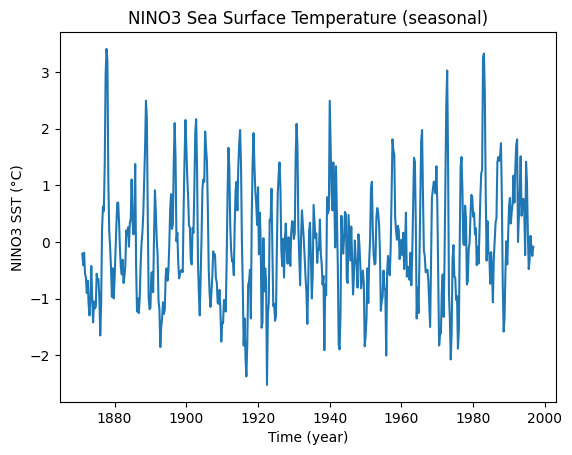

In [ ]:
#Input time series data dan normalisasi data
sst=np.loadtxt('LIMA/ANDAT/Data/sst_nino3.dat')
variance=np.std(sst)
sst=(sst-np.mean(sst))/np.std(sst)
print(len(sst))

#Buat array berisi waktu
n=len(sst)
dt=0.25
time=np.arange(len(sst))*dt + 1871

#Batas tahun untuk plot
xlim=[1871,1997]

#Plot data Nino3
plt.plot(time,sst)
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('NINO3 Sea Surface Temperature (seasonal)')

### Wavelet

###### Langkah Wavelet

In [ ]:
# a. pengaturan parameter wavelet

data=sst              #Data
dj=0.25               #Increment scale
pad=0                 #Time series diset nilai 0 (Default)
s0=2*dt               #Scale dimulai 6 bulanan (Default) | s0 merupakan scale terkecil dari Wavelet
j1=7/dj               #Jumlah scale - 1 | Rentang  scale dari s0 sampai s0*2**(j1*dj) dengan jumlah scale sebanyak (j1+1)
mother='MORLET'       #Shape Wavelet ada: Morlet, Difference of Gaussian (DOG), Paul)
lag1=0.72             #Lag-1 autocorrelation digunakan untuk level signifikansi

# b. transformasi wavelet

wave, period, scale, coi = wavelet(data, dt=dt, pad=pad, dj=dj, s0=s0, J1=j1, mother=mother)  # fungsi wavelet
power=(np.abs(wave))**2                                                                       # hitung wavelet power spectrum
global_ws=(np.sum(power,axis=1))/n                                                            # time-average over all scale (global_ws)

# c. pengaturan selang kepercayaan

signif = wave_signif(variance,dt=dt,scale=scale,sigtest=0,lag1=lag1,mother=mother)  # fungsi signifikansi
sig95=signif[:,np.newaxis].dot(np.ones(n)[np.newaxis,:])                            # buat signif --> (J+1)x(N) array
sig95=power/sig95                                                                   # ketika ratio power dan signif > 1, power signifikan

# d. spektrum wavelet dan selang kepercayaan

dof = n-scale                                                                                      # the scale corrects for padding at edges
global_signif = wave_signif(variance,dt=dt,scale=scale,sigtest=1,lag1=lag1,dof=dof,mother=mother)  # fungsi signifikansi untuk global_ws

# e. scale-average pada rentang periode 2 dan 8

avg=np.logical_and(scale>=2,scale<8)                                                              # Logika untuk mengambil rentang skala 2 - 8
Cdelta=0.776                                                                                      # Cdelta untuk MORLET wavelet
scale_avg=scale[:,np.newaxis].dot(np.ones(n)[np.newaxis,:])                                       # buat scale --> (J+1)x(N) array
scale_avg=power/scale_avg                                                                         # [Eqn(24)] di referensi
scale_avg=dj*dt/Cdelta*sum(scale_avg[avg,:])                                                      # [Eqn(24)] di referensi
scale_signif = wave_signif(variance,dt=dt,scale=scale,sigtest=2,lag1=lag1,dof=[2,7],mother=mother)# fungsi signifikansi untuk scale average

##### Plot

In [ ]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec

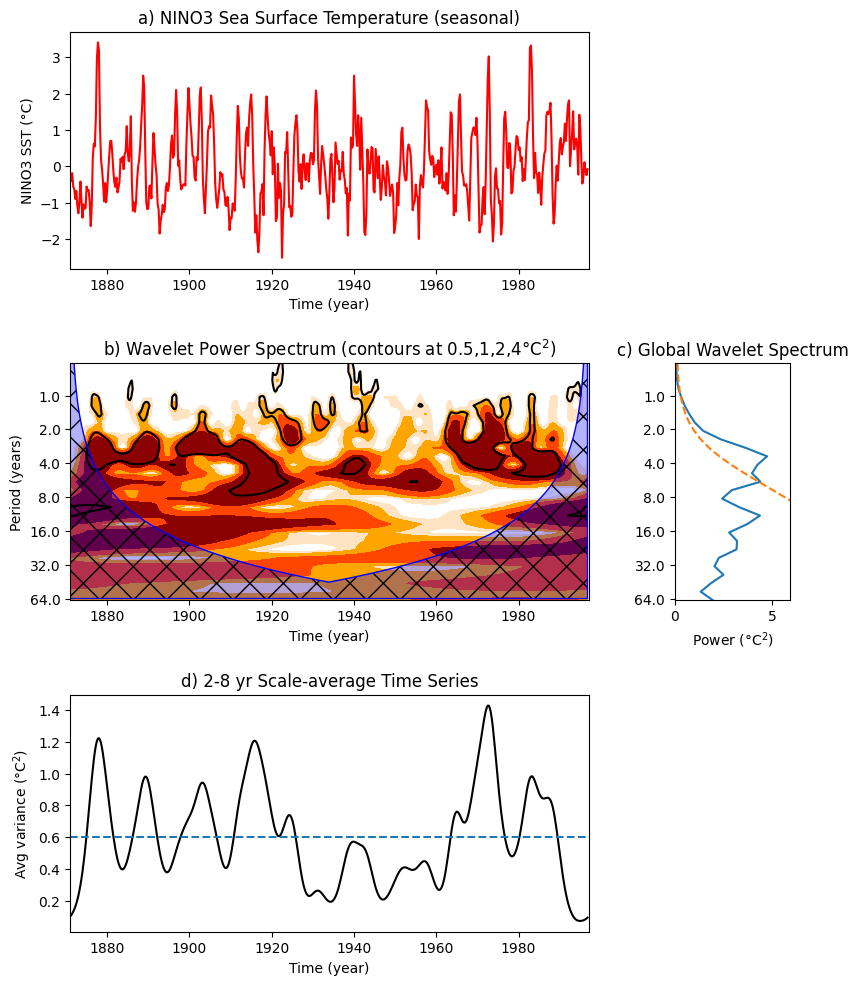

In [ ]:
#------------------------------------------------------ Plotting

#--- Plot time series
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(time, sst, 'red')
#plt.plot(time,iwave,'k--')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')


#--- Contour plot wavelet power spectrum
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 999]
CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=levels, colors=['white','bisque','orange','orangered','darkred'])
plt.xlabel('Time (year)')
plt.ylabel('Period (years)')
plt.title('b) Wavelet Power Spectrum (contours at 0.5,1,2,4\u00B0C$^2$)')
plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = plt.plot(ts_area,(coi_area),'blue',linewidth=1)
F=plt.fill(ts_area,(coi_area),'blue',alpha=0.3,hatch="x")

# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
# set up the size and location of the colorbar
# position=fig.add_axes([0.5,0.36,0.2,0.01])
#plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)


# plt.subplots_adjust(right=0.7, top=0.9)

#--- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt.ylim([np.min(period), np.max(period)])
plt4.set_yscale('log', base=2, subs=None)
ax = plt.gca().yaxis
ax.set_major_formatter(ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()


# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.plot(xlim,scale_signif+[0,0],'--')
plt.xlim(xlim[:])

plt.xlabel('Time (year)')
plt.ylabel('Avg variance (\u00B0C$^2$)')
plt.title('d) 2-8 yr Scale-average Time Series')

plt.show()


# end of code